# Averserial learning at scale - Kurakin et al
Here we give an insight in several adverserial attack methods that were studied in the paper by Kurakin (2017). We show the performance of the methods in preventing the correct classification of a simple example image. As model we used the pretrained ResNet-50 model for classification of the ImageNet dataset.

Similar to Kurakin (2017), we will use the following notations:

$$
\begin{align}
\boldsymbol{X}&\quad \text{the original input image}\\
\boldsymbol{X}^{adv}&\quad \text{the adverserial image which is computed by the advererial attack methods}\\
y&\quad \text{classification label}\\
\epsilon &\quad \text{The size of the perturbation, expressed in terms of pixel values} \in [0,\, 255]\\
J(\boldsymbol{X}, y_{true})&\quad \text{cost function used to train the model}\\
Clip_{\boldsymbol{X},\epsilon}(\boldsymbol{A}) &\quad \text{element wise clipping of } \boldsymbol{A} \text{, with } A_{i,j} \text{ clipped to the range } [\boldsymbol{X}_{i,j} - \epsilon, \boldsymbol{X}_{i,j} + \epsilon]
\end{align}
$$

In [72]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

import json
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.autograd import Variable
import torch.nn.functional as F

In [109]:
# Read the example image
image = Image.open("kopje.jpg")
# Reel free to change kopje.jpg to any other image, such as pig.jpg. 
# The parameters might need retuning in that case
#image = Image.open("pig.jpg")

# Standard normalization values for ImageNet images, 
# obtained from https://github.com/pytorch/examples/blob/master/imagenet/main.py
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


# Resize to 224, convert to PyTorch Tensor and perform normalizationa
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
   transforms.Normalize(mean, std)
])

# Add batch dimension
image_tensor = preprocess(image).unsqueeze(0)

image_variable = Variable(image_tensor, requires_grad=True)

In [110]:
def show_image(image_variable, pred_label, prob):
    """
    
    """
    # remove batch dimension
    img = image_variable.squeeze(0)
    
    # Undo normalizations
    img = img.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).detach().numpy()

    # Convert C X H X W -->  H X W X C
    img = np.transpose(img, (1,2,0))   
    img = np.clip(img, 0, 1)
    
    figure, ax = plt.subplots(1,1, figsize=(4,4))
    
    ax.imshow(img)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

    
    ax.text(0.5, -0.2,
            'Prediction: {}\n Probability: {:.4f}'.format(pred_label, prob),
            size=12, ha="center", transform=ax.transAxes)
    
    plt.show()
    

In [111]:
# Load pre-trained ResNet50, and put model into| evaluation mode 
model = resnet50(pretrained=True)
model.eval();


In [112]:
# Load labels corresponding to ImageNet class indices
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}

# Original model performance
Here, we show the performance of the model on the original image. The image is correctly classified as 'espresso' with high probability.

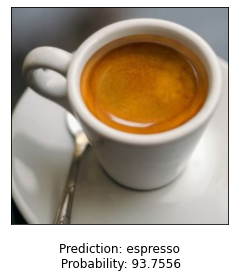

In [113]:
pred = model(image_variable)

pred_label = imagenet_classes[pred.max(dim=1)[1].item()]
probs = F.softmax(pred, dim=1)
prob = torch.max(probs.data, 1)[0][0] * 100

# plot image
show_image(image_variable, pred_label, prob)


# Fast Gradient Sign Method
Now we apply the Fast Gradient Sign Method (FGSM). The FGSM method was first proposed by Goodfellow (2015). It is a one-step method, that is easy to compute. The computation of the adverserial  image is done as follows:

$$
\boldsymbol{X}^{adv} = \boldsymbol{X} + \epsilon\, \text{sign}{\nabla_x J(\boldsymbol{X}, y_{true})}
$$

Here follows the implementation in pytorch:

In [119]:
y_true = 967
epsilon = 2/255

pred = model(image_variable)

model.zero_grad()

loss = nn.CrossEntropyLoss()(pred, torch.LongTensor([y_true]))

loss.backward(retain_graph=True)

perturbed_image = image_variable + epsilon * image_variable.grad.data.sign()

pred_perturbed = model(perturbed_image)

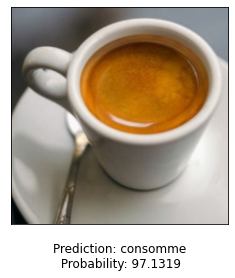

In [120]:
pred_label = imagenet_classes[pred_perturbed.max(dim=1)[1].item()]
probs = F.softmax(pred_perturbed, dim=1)
prob = torch.max(probs.data, 1)[0][0] * 100

# plot image
show_image(perturbed_image, pred_label, prob)

As can be seen from the result above, the image is still correctly predicted. However the probability is much lower.

# One step least-likely class
A variation of the FGSM method, that aims to maximize the probability $P(y_{target} | \boldsymbol{X})$ towards a target class $y_{target}$ that is not likely for the current input. In this single-step method, the adverserial image $\boldsymbol{X}^{adv}$ is computed as follows:
$$
\boldsymbol{X}^{adv} = \boldsymbol{X} - \epsilon\, \text{sign}{\nabla_x J(\boldsymbol{X}, y_{LL})}
$$
Where $y_{LL} = \arg \min_y p(y | \boldsymbol{X})$ represents the least likely class.

In [121]:
# find least likely class
pred = model(image_variable)
y_target = torch.argmin(pred).item()
print('least likely class: {}'.format(imagenet_classes[y_target]))

epsilon = 2/255

pred = model(image_variable)

model.zero_grad()

loss = nn.CrossEntropyLoss()(pred, torch.LongTensor([y_target]))

loss.backward(retain_graph=True)

perturbed_image = image_variable - epsilon * image_variable.grad.data.sign()

pred_perturbed = model(perturbed_image)

least likely class: dam


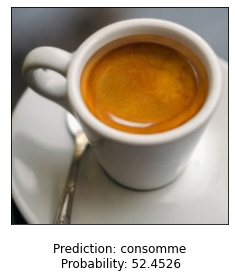

In [122]:
pred_label = imagenet_classes[pred_perturbed.max(dim=1)[1].item()]
probs = F.softmax(pred_perturbed, dim=1)
prob = torch.max(probs.data, 1)[0][0] * 100

# plot image
show_image(perturbed_image, pred_label, prob)

# Basic iterative method attack

Iterative methods apply many gradient updates. The Basic iterative method extends FGSM method, by applying the FGSM method multiple times with small step size:

$$
\boldsymbol{X}^{adv}_0 = \boldsymbol{X},\quad \boldsymbol{X}^{adv}_{N+1} = Clip_{\boldsymbol{X},\epsilon} \{ \boldsymbol{X}^{adv}_{N} + \epsilon\, \text{sign}\nabla_x J(\boldsymbol{X}^{adv}_{N}, y_{true}) \}
$$

In [103]:
# reset the gradients
image_variable.grad.data.zero_()

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [130]:
y_true = 967
epsilon = 0.2
alpha = .25
num_steps = 3

for i in range(num_steps):
    
    pred = model(image_variable)

    loss = nn.CrossEntropyLoss()(pred, torch.LongTensor([y_true]))
    
    loss.backward()
        
    x_adv_temp = image_variable.data + alpha * image_variable.grad.data.sign()
    
    total_grad = x_adv_temp - image_tensor
    
    image_variable.data = image_tensor + total_grad.data.clamp(-epsilon, epsilon)


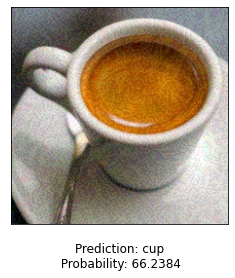

In [131]:
pred = model(image_variable)

pred_label = imagenet_classes[pred.max(dim=1)[1].item()]
probs = F.softmax(pred, dim=1)
prob = torch.max(probs.data, 1)[0][0] * 100

# plot image
show_image(image_variable, pred_label, prob)


In [132]:
# reset the gradients
image_variable.grad.data.zero_()

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

# Iterative leasy-likely class method
An iterative method that applies the one-step least-likely class method multiple times:
$$
\boldsymbol{X}^{adv}_0 = \boldsymbol{X},\quad \boldsymbol{X}^{adv}_{N+1} = Clip_{\boldsymbol{X},\epsilon} \{ \boldsymbol{X}^{adv}_{N} - \epsilon\, \text{sign}\nabla_x J(\boldsymbol{X}^{adv}_{N}, y_{LL})\}
$$

In [133]:
# find least likely class
pred = model(image_variable)
y_target = torch.argmin(pred).item()
print('least likely class: {}'.format(imagenet_classes[y_target]))

epsilon = 0.3
alpha = 0.025
num_steps = 7

for i in range(num_steps):
    
    pred = model(image_variable)

    loss = nn.CrossEntropyLoss()(pred, torch.LongTensor([y_target]))
    
    loss.backward()
        
    x_adv_temp = image_variable.data - alpha * image_variable.grad.data.sign()
    
    total_grad = x_adv_temp - image_tensor
    
    image_variable.data = image_tensor + total_grad.data.clamp(-epsilon, epsilon)


least likely class: black_stork


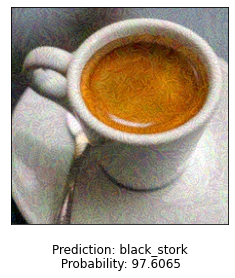

In [134]:
pred = model(image_variable)

pred_label = imagenet_classes[pred.max(dim=1)[1].item()]
probs = F.softmax(pred, dim=1)
prob = torch.max(probs.data, 1)[0][0] * 100

# plot image
show_image(image_variable, pred_label, prob)


# Performance on adverserial trained model

# References

Goodfellow, I. J., Shlens, J., & Szegedy, C. (2015). Explaining and Harnessing Adversarial Examples. ArXiv:1412.6572 [Cs, Stat]. http://arxiv.org/abs/1412.6572

Kurakin, A., Goodfellow, I., & Bengio, S. (2017). Adversarial Machine Learning at Scale. ArXiv:1611.01236 [Cs, Stat]. http://arxiv.org/abs/1611.01236

